## 1 Setup

### 1.1 Import and configure libraries

In [314]:
# pip install --upgrade tensorflow after restart kernel

In [315]:
# Data manipulation libraries
import numpy as np
import pandas as pd
import scipy as sp
from scipy.spatial import distance


# Data visualization libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns
from prettytable import PrettyTable

# General Imports
import os
import re
from tqdm import tqdm
from colorama import Fore, Style
import random

# Text processing and cleaning
import unicodedata
import re

# Data modeling libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras import utils
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import save_model


import sklearn
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



# Library versions
print("Numpy version:", np.__version__)
print("Scipy version:", sp.__version__)  # Commented out since spacy is not imported
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)
print("TensorFlow version:", tf.__version__)
print("Scikit-learn version:", sklearn.__version__)

# Configure Numpy
# specify that the maximum width of printed lines should be 130 characters
# after 130 characters, it will continue in the next line
np.set_printoptions(linewidth=130)

# Configure Seaborn
sns.set_style("whitegrid")  # set white background with grid
sns.set_palette("deep")  # set color palette
sns.set_context("paper", font_scale=1.25)  # set font to scale 1.25, greater than default


Numpy version: 1.24.3
Scipy version: 1.11.4
Pandas version: 2.0.3
Matplotlib version: 3.7.4
Seaborn version: 0.12.2
TensorFlow version: 2.13.0
Scikit-learn version: 1.2.2


### 1.2 Constants and helper functions

In [316]:
INPUT_CSV = "/kaggle/input/bbc-text-classification-1-text-preprocessing/docs_stage_3_preprocessed.csv"


LOGS_DIR = "/kaggle/working/logs"
MODELS_DIR = "/kaggle/working/models"
MODEL_FILE = "/kaggle/working/models/epoch-{epoch:02d}_accuracy-{val_accuracy:.4f}.keras"


CLASS_COUNT = 5  # Class-label count.
OUTPUT_DIM = 100  # Word embedding output dimension.

# Epochs limit for EarlyStopping.
# Number of epochs with no improvement after which training will be stopped.
PATIENCE = 3

# Encoded class-labels from BBC Text classification - 1. Text preprocessing
cls_map = {'Business' : 0, 'Entertainment': 1, 'Politics': 2, 'Sport': 3, 'Tech' : 4}

### Helper functions

In [317]:
def show_n_vals(vec, n):
    """Helper function to print the first n values of a vector."""
    if vec is not None:
        return vec[:n]
    else:
        return None

def cosine_sim(gvec_index, word1, word2):
    """
    Function to compute cosine-similarity between
    two input words based on their GloVe vectors.
    """
    # Retrieve GloVe vectors for the input words
    vec1 = gvec_index.get(word1.lower())
    vec2 = gvec_index.get(word2.lower())

    if vec1 is not None and vec2 is not None:
        print(f"GloVe vector for '{word1}': {show_n_vals(vec1, 3)}")
        print(f"GloVe vector for '{word2}': {show_n_vals(vec2, 3)}")

        # Compute cosine similarity
        c_dist = distance.cosine(vec1, vec2) #Compute the Cosine distance between 1-D arrays.
        print(f"Cosine similarity between '{word1}' and '{word2}': {round(c_dist, 4)}")
        # 1 - c_dist is used to convert cosine distance to similarity
    else:
        print(f"One or both words not found in the GloVe index.")

# Example usage:
# cosine_sim(gvec_index, "Color", "Colour")


###  Reset Directories

Remove logs and saved models from previous run.

In [318]:
shutil.rmtree(LOGS_DIR, ignore_errors=True)
shutil.rmtree(MODELS_DIR, ignore_errors=True)

### 1.3 Load dataset

In [319]:
docs = pd.read_csv(INPUT_CSV)
docs.head(10)

,DocId,DocTextlen,DocText,ADJ,ADP,ADV,AUX,CCONJ,DET,NOUN,...,PUNCT,SCONJ,SYM,VERB,X,INTJ,DocType,FileSize,FilePath,DocCat
0,P_361,3110,budget to set scene for election gordon brown ...,41,61,17.0,29.0,12.0,61,144,...,58,9.0,8.0,65,0.0,0.0,Politics,3132,/kaggle/input/bbc-full-text-document-classific...,0
1,P_245,3013,army chief in regiment decision military chief...,38,57,15.0,32.0,22.0,69,97,...,47,6.0,0.0,62,0.0,0.0,Politics,3018,/kaggle/input/bbc-full-text-document-classific...,0
2,P_141,3143,howard deny split over id card michael howard ...,31,43,12.0,47.0,14.0,52,109,...,74,15.0,0.0,94,1.0,0.0,Politics,3153,/kaggle/input/bbc-full-text-document-classific...,0
3,P_372,3074,observer to monitor uk election ministers will...,44,62,17.0,32.0,11.0,41,110,...,61,10.0,1.0,75,0.0,0.0,Politics,3082,/kaggle/input/bbc-full-text-document-classific...,0
4,P_333,2598,kilroy name election seat target ex - chat sho...,35,50,10.0,26.0,7.0,40,88,...,74,6.0,0.0,52,2.0,1.0,Politics,2604,/kaggle/input/bbc-full-text-document-classific...,0
5,P_276,2770,donor attack blair - brown ' feud ' the report...,39,43,12.0,30.0,16.0,46,95,...,60,8.0,1.0,62,0.0,0.0,Politics,2780,/kaggle/input/bbc-full-text-document-classific...,0
6,P_244,2882,research fear over kelly 's view scientist hav...,43,45,13.0,40.0,10.0,34,114,...,62,11.0,0.0,50,0.0,0.0,Politics,2889,/kaggle/input/bbc-full-text-document-classific...,0
7,P_175,2374,chancellor rally labour voter gordon brown hav...,28,54,13.0,14.0,20.0,40,108,...,60,0.0,3.0,49,0.0,0.0,Politics,2384,/kaggle/input/bbc-full-text-document-classific...,0
8,P_351,2977,fox attack blair 's tory ' lie ' tony blair li...,25,49,14.0,30.0,21.0,48,92,...,76,13.0,2.0,74,0.0,0.0,Politics,2990,/kaggle/input/bbc-full-text-document-classific...,0
9,P_265,2134,tory unveil quango blitz plan plan to abolish ...,35,31,7.0,31.0,12.0,27,85,...,50,3.0,1.0,50,0.0,0.0,Politics,2142,/kaggle/input/bbc-full-text-document-classific...,0


## 2 Exploratory Data Analysis

In [320]:
rows, cols = docs.shape
print(f"Dataset contains {rows} rows and {cols} columns.\n")
      
docs.info()

Dataset contains 2205 rows and 24 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DocId       2205 non-null   object 
 1   DocTextlen  2205 non-null   int64  
 2   DocText     2205 non-null   object 
 3   ADJ         2205 non-null   int64  
 4   ADP         2205 non-null   int64  
 5   ADV         2205 non-null   float64
 6   AUX         2205 non-null   float64
 7   CCONJ       2205 non-null   float64
 8   DET         2205 non-null   int64  
 9   NOUN        2205 non-null   int64  
 10  NUM         2205 non-null   float64
 11  PART        2205 non-null   float64
 12  PRON        2205 non-null   float64
 13  PROPN       2205 non-null   int64  
 14  PUNCT       2205 non-null   int64  
 15  SCONJ       2205 non-null   float64
 16  SYM         2205 non-null   float64
 17  VERB        2205 non-null   int64  
 18  X           2205 non-nul

#### Remarks

* Featurs `DocText` and `DocCat` is not missing any data.

> **Note**: For complete Exploratory Data Analysis refer PART 1: [BBC Text classification - 1. Text preprocessing][1].

[1]: https://www.kaggle.com/code/diaconumadalina/bbc-text-classification-1-text-preprocessing

## 3 Feature Engineering

### 3.1 Tokenization


To prepare text data for machine learning, it's essential to convert words into a numerical format. This process, known as integer encoding, assigns a unique integer to each word in the text. The Keras library provides a convenient tool called the `Tokenizer` API to perform this task.


Ref: [Tokenization and Text Data Preparation with TensorFlow & Keras][1]

[1]: https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html

#### Tokenizer

In [321]:
tokenizer = Tokenizer(
    num_words = 5000, # Limit the number of words to consider based on frequency.
    filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', # Define characters to filter out.
    oov_token = "<UNK>" # Out-of-vocabulary token to represent words not in the vocabulary.
)

tokenizer.fit_on_texts(docs["DocText"].values)

#### Word Index

In [322]:
word_index = tokenizer.word_index
vocabulary_size = len(word_index)

print("Words from vocabulary:", vocabulary_size)
print("\nFirst 15 words:\n")
for word, index in list(word_index.items())[:15]:
    print(f"{word}: {index}")

Words from vocabulary: 23375

First 15 words:

<UNK>: 1
the: 2
be: 3
to: 4
of: 5
and: 6
a: 7
in: 8
have: 9
say: 10
for: 11
that: 12
on: 13
it: 14
's: 15


In [323]:
# word_index.items()

#### Sequencing

In [324]:
en_docs = tokenizer.texts_to_sequences(docs["DocText"].values)

print("Sequence information:")
print("Data type:", type(en_docs))
print("Total count:", len(en_docs))
print("\nSample lengths and elements:")
_ = [print(f"Length: {len(seq)}, Elements: {seq[:5]}") for seq in en_docs[:3]]


Sequence information:
Data type: <class 'list'>
Total count: 2205

Sample lengths and elements:
Length: 555, Elements: [406, 4, 112, 1298, 11]
Length: 506, Elements: [3394, 235, 8, 3113, 269]
Length: 546, Elements: [310, 553, 1893, 64, 1254]


In [325]:
seq_lengths = [len(x) for x in en_docs]

# Get max training sequence length.
max_len = np.max(seq_lengths)
print("Longest sequence of length:", max_len)

# Get max training sequence length.
min_len = np.min(seq_lengths)
print("Shortest sequence of length:", min_len)


Longest sequence of length: 1091
Shortest sequence of length: 91


#### Distribution of sequence length

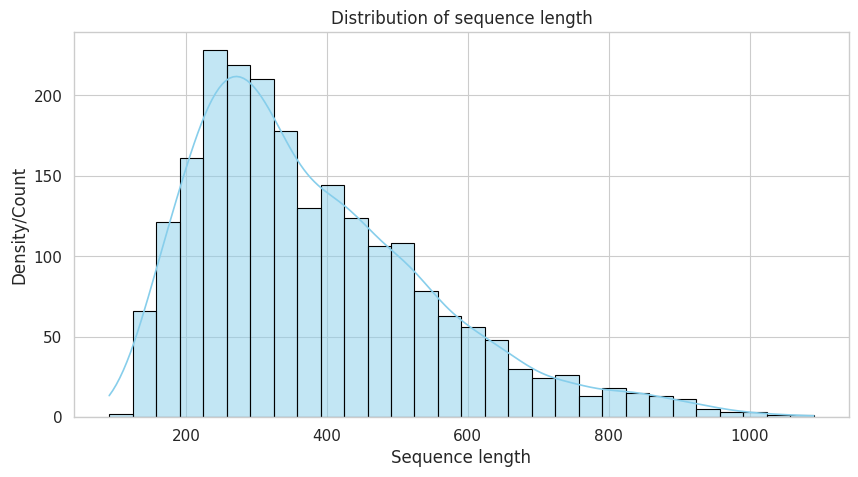

In [326]:
plt.figure(figsize=(10, 5))
sns.histplot(x=seq_lengths, kde=True, color='skyblue', edgecolor='black')
plt.xlabel("Sequence length")
plt.ylabel("Density/Count")
plt.title("Distribution of sequence length")
plt.show()


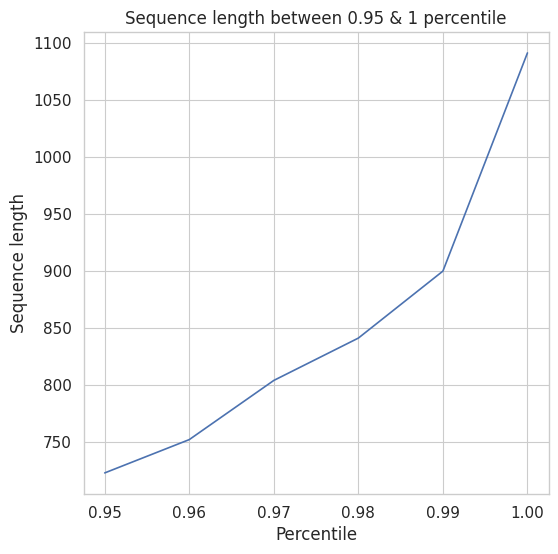

In [327]:
ll, hl = 0.95, 1
plt.figure(figsize=(6, 6))

x = np.arange(ll, hl, 0.01)
y = np.quantile(a=np.array(seq_lengths), q=x)
# x is an array of quantiles ranging from 0.95 to 1 with a step size of 0.01. 
# When you calculate the quantiles using np.quantile, the q parameter (quantiles) specifies the array of quantiles to compute.
sns.lineplot(x=x, y=y)
plt.title(f"Sequence length between {ll} & {hl} percentile")
plt.xlabel("Percentile")
plt.ylabel("Sequence length")

plt.show()

#### Remarks

~99% of documnents have sequence length less than 900.

### 3.2 Padding


In [328]:
seq_len = 900  # Adjust as needed

# Pad sequences
pad_docs = pad_sequences(en_docs, maxlen=seq_len, padding="post", truncating="post")

# Display padded sequences information
print("Padded sequences:")
print("Data type:", type(pad_docs), "Shape:", pad_docs.shape)
print("Sample values:")
print(pad_docs)

# This code uses the pad_sequences function from tensorflow.keras.preprocessing.sequence to pad sequences to a specified length (seq_len). 
# The padding="post" parameter ensures padding is added at the end of the sequences, and truncating="post" truncates sequences from the end if they exceed the specified length.

Padded sequences:
Data type: <class 'numpy.ndarray'> Shape: (2205, 900)
Sample values:
[[ 406    4  112 ...    0    0    0]
 [3394  235    8 ...    0    0    0]
 [ 310  553 1893 ...    0    0    0]
 ...
 [ 672  757 1079 ...    0    0    0]
 [ 115  952  202 ...    0    0    0]
 [  52  404 1717 ...    0    0    0]]


### 3.3 GloVe Vectors

Load vector representation of words


In [329]:
%%time

# load the whole embedding.

def load_glove_vectors(file_path):
    with open(file_path, encoding="utf8") as txt_f:
        for line in txt_f:
            columns = line.split()
            wrd = columns[0]
            vec = np.array(columns[1:], dtype="float32")
            yield wrd, vec

# Provide the path to your GloVe file
GLOVE_TXT = '/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt'  # Adjust the file path and dimensions
gvec_index = dict(load_glove_vectors(GLOVE_TXT))


CPU times: user 7.08 s, sys: 123 ms, total: 7.2 s
Wall time: 7.16 s


In [330]:
list(gvec_index.items())[0]
# gvec_index.keys()
# gvec_index

('the',
 array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01, -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04,
        -6.5660e-01,  2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,  1.1658e-02,  1.0204e-01, -1.2792e-01,
        -8.4430e-01, -1.2181e-01, -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01, -1.8823e+00, -7.6746e-01,
         9.9051e-02, -4.2125e-01, -1.9526e-01,  4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,  7.4449e-03,
         1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02, -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
         1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01], dtype=float32))

In [331]:
def show_n_vals(vector, n=3):
    return f"{vector[:n]} ... {vector[-n:]}"

print("Total number of words in GloVe index:", len(gvec_index))
print("Sample word vectors:")

table = PrettyTable(["Word", "Pre-trained Vectors"])
# table.align["Word"] = "l"
# table.align["Pre-trained Vectors"] = "l"

# Display a subset of words and their vectors
for word, vector in list(gvec_index.items())[:5]:
    table.add_row([word, show_n_vals(vector)])

print(table)


Total number of words in GloVe index: 400000
Sample word vectors:
+------+---------------------------------------------------------------------+
| Word |                         Pre-trained Vectors                         |
+------+---------------------------------------------------------------------+
| the  |    [ 0.418    0.24968 -0.41242] ... [-0.18411 -0.11514 -0.78581]    |
|  ,   | [ 0.013441  0.23682  -0.16899 ] ... [-0.56657   0.044691  0.30392 ] |
|  .   |   [ 0.15164  0.30177 -0.16763] ... [-0.35652   0.016413  0.10216 ]  |
|  of  |   [ 0.70853  0.57088 -0.4716 ] ... [-0.22562  -0.093918 -0.80375 ]  |
|  to  | [ 0.68047  -0.039263  0.30186 ] ... [-0.073297 -0.064699 -0.26044 ] |
+------+---------------------------------------------------------------------+


### Missing words


In [332]:
word_set = set(word_index.keys())
gvec_set = set(gvec_index.keys())

missing_words_set = word_set - gvec_set
misc = len(missing_words_set)
misp = round(misc / len(word_set) * 100, 1)

print(f"{misc}, {misp}% words in our vocabulary do not have GloVe vectors.")


1311, 5.6% words in our vocabulary do not have GloVe vectors.


### Load weights


In [333]:
# OUTPUT_DIM = 100  #  the output dimensionality of word vectors 
# All zero-valued vector
zero_vec = np.zeros(OUTPUT_DIM)

# Create a list of word vectors using list comprehension
weights = [gvec_index.get(word, zero_vec).tolist() for word in word_index.keys()]

# Prepend a zero vector for <PAD>
weights = [zero_vec.tolist()] + weights

# Ensure all word vectors have the same dimensionality
max_len = max(len(vec) for vec in weights) #It calculates the maximum length among all word vectors in weights 
weights = [vec + [0.0] * (max_len - len(vec)) for vec in weights] #and pads shorter vectors with zeros to make them have the same dimensionality as the maximum length.

# Convert the list of lists to a TensorFlow constant tensor
weights = tf.constant(weights, dtype=tf.float32)

print("Weights datatype:", weights.dtype)
print("Weights shape:", weights.shape)

# weight matrix has 23,376 rows and 100 columns. Each row corresponds to a word in your vocabulary, and each column represents a feature in the word vectors with a dimensionality of 100.

Weights datatype: <dtype: 'float32'>
Weights shape: (23376, 100)


### 3.4 Cosine Similarity


1. GloVe provides word vectors for both American English and British English words.

2. All words in GloVe embeddings are in lowercase.

3. Cosine similarity ranges between 0 and 1.

4. Zero indicates the least distance, meaning the highest similarity, while one indicates the maximum distance, implying the lowest similarity.


#### Example 1: American English vs British English (Color vs Colour)

In [334]:
cosine_sim(gvec_index, "Color", "Colour")

GloVe vector for 'Color': [-0.86832  0.98449 -0.24756] ... [-0.4299     0.0092608  0.13798  ]
GloVe vector for 'Colour': [-0.58068  0.90569 -0.73373] ... [-0.26844  0.30489 -0.40387]
Cosine similarity between 'Color' and 'Colour': 0.1089


#### Example 2: Dissimilar words (Pasta vs Lithium)

In [335]:
cosine_sim(gvec_index, "Pasta", "Lithium")

GloVe vector for 'Pasta': [ 0.79324 -0.26557 -1.1389 ] ... [0.14356 0.55204 0.58175]
GloVe vector for 'Lithium': [0.78971 0.58855 1.4308 ] ... [-0.072204  0.04719  -0.076418]
Cosine similarity between 'Pasta' and 'Lithium': 0.651


### 3.5 POS features

Calculate the frequency of each part-of-speech category in a given document and integrate these counts alongside padded sequences as input for a neural network.

In [336]:
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DocId       2205 non-null   object 
 1   DocTextlen  2205 non-null   int64  
 2   DocText     2205 non-null   object 
 3   ADJ         2205 non-null   int64  
 4   ADP         2205 non-null   int64  
 5   ADV         2205 non-null   float64
 6   AUX         2205 non-null   float64
 7   CCONJ       2205 non-null   float64
 8   DET         2205 non-null   int64  
 9   NOUN        2205 non-null   int64  
 10  NUM         2205 non-null   float64
 11  PART        2205 non-null   float64
 12  PRON        2205 non-null   float64
 13  PROPN       2205 non-null   int64  
 14  PUNCT       2205 non-null   int64  
 15  SCONJ       2205 non-null   float64
 16  SYM         2205 non-null   float64
 17  VERB        2205 non-null   int64  
 18  X           2205 non-null   float64
 19  INTJ        2205 non-null  

In [337]:
docs.iloc[:, 3:18].astype("int32").head()

,ADJ,ADP,ADV,AUX,CCONJ,DET,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB
0,41,61,17,29,12,61,144,11,21,24,47,58,9,8,65
1,38,57,15,32,22,69,97,6,17,26,59,47,6,0,62
2,31,43,12,47,14,52,109,0,23,47,60,74,15,0,94
3,44,62,17,32,11,41,110,15,21,21,43,61,10,1,75
4,35,50,10,26,7,40,88,7,20,32,88,74,6,0,52


## 4 Custom Callbacks

### 4.1 Callback #1: `PerformanceMetrics`

Create a callback in Python using Keras that calculates and prints the micro F1 score for the validation dataset during the training of a neural network.

In [338]:
class PerformanceMetrics(callbacks.Callback):
    def __init__(self, X_test, y_test):
        super(PerformanceMetrics, self).__init__()
        self.X_test = X_test
        self.y_test = y_test

    def calculate_micro_f1(self):
        # Predict on the validation data
        cl_prob = self.model.predict(self.X_test)
        y_pred = np.argmax(cl_prob, axis=1)

        # Calculate micro F1 score
        f1_scr = f1_score(self.y_test, y_pred, average="micro")
        return f1_scr

    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            # Stop propagation of callbacks.
            return

        # Calculate micro F1 score
        f1_scr = self.calculate_micro_f1()

        # Print the F1 score
        print(f"Epoch {epoch + 1} - Validation Micro F1 Score: {round(f1_scr, 4)}") # When reporting progress or results to users, it's common to start counting from 1 (e.g., "Epoch 1" instead of "Epoch 0")

# Example usage:
# Assuming you have a model (model), validation data (X_val, y_val), and a fitting process
# metrics_callback = PerformanceMetrics(X_test=X_val, y_test=y_val)
# model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[metrics_callback])

### 4.2 Callback #2: `SaveBetterModel`

A callback is implemented to save the model after each training epoch, but only if the validation accuracy has improved compared to the previous epoch. This ensures that only models with better validation performance are saved during the training process.


In [339]:
# FOR HDF5 FORMAT FOR SAVE MODEL_FILE = "/kaggle/working/models/epoch-{epoch:02d}_accuracy-{val_accuracy:.4f}.HDF5"


# class SaveBetterModel(callbacks.ModelCheckpoint):
#     def __init__(self, **kwargs):
#         super().__init__(
#             monitor="val_accuracy",
#             verbose=2,
#             save_best_only=True,
#             mode="max",
#             **kwargs,
#         )

#     def on_epoch_end(self, epoch, logs=None):
#         # To stop propagation of callbacks.
#         if self.model.stop_training:
#             return

#         super().on_epoch_end(epoch, logs) # The epoch and logs parameters provide information about the current training state.
        
# FOR keras FORMAT FOR SAVE MODEL_FILE = "/kaggle/working/models/epoch-{epoch:02d}_accuracy-{val_accuracy:.4f}.keras"

class SaveBetterModel(Callback):
    def __init__(self, filepath, monitor='val_accuracy', save_best_only=True, mode='max', verbose=0):
        super(SaveBetterModel, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.save_best_only = save_best_only
        self.mode = mode
        self.verbose = verbose
        self.best_value = None

    def on_epoch_end(self, epoch, logs=None):
        current_value = logs.get(self.monitor)
        if current_value is None:
            return

        if self.best_value is None or (current_value > self.best_value and self.mode == 'max'):
            self.best_value = current_value
            save_model(self.model, self.filepath, overwrite=True)
            if self.verbose > 0:
                print(f"\nEpoch {epoch + 1}: {self.monitor} improved from -inf to {current_value}, saving model to {self.filepath}")





### 4.3 Callback #3: `TerminateWhenNaN`

In [340]:
class TerminateWhenNaN(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Check if training should be stopped by a previous callback.
        if self.model.stop_training:
            return

        # Retrieve the loss value from the training logs.
        loss = logs.get("loss")

        # Check if the loss is invalid (NaN or infinity).
        if (loss is not None) and (np.isnan(loss) or np.isinf(loss)): #The overall expression is using negation to check for the absence of a valid loss value.
            print(f"Training terminated at epoch {epoch}: Invalid loss value ({loss}).")

            # Inform the training loop to stop further epochs.
            self.model.stop_training = True


### 4.4 Callback #4: `DecayLearningRate`

1. If the accuracy on the validation dataset decreases in the current epoch compared to the previous epoch, decrease the learning rate by 10%.
2. Every third epoch, decrease the learning rate by 5%.

In [341]:
class DecayLearningRate(callbacks.Callback):
    def __init__(self):
        self.prev_val_acc = 0  # previous validation accuracy.

    def get_learning_rate(self):
        return float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))

    def set_learning_rate(self, new_lr):
        tf.keras.backend.set_value(self.model.optimizer.learning_rate, new_lr)

    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            return

        curr_val_acc = logs.get("val_accuracy")
        lr = self.get_learning_rate()

        if curr_val_acc < self.prev_val_acc:
            reduction_percentage = 10
        elif (epoch + 1) % 3 == 0:
            reduction_percentage = 5
        else:
            reduction_percentage = 0

        if reduction_percentage > 0:
            new_lr = lr * (1 - reduction_percentage / 100)
            self.set_learning_rate(new_lr)
            print(f"Reducing learning rate by {reduction_percentage}%. New learning rate: {round(new_lr, 6)}")

        self.prev_val_acc = curr_val_acc


### 4.5 Callback #5: `TerminateOnNoChange`

**Early stopping** is a training optimization technique that automatically halts the training of a machine learning model when its performance on a validation set stops improving. This prevents overfitting and helps find the best model without unnecessary computational costs.

In [342]:
class TerminateOnNoChange(callbacks.EarlyStopping):
    def __init__(self, epochs):
        super().__init__(
            monitor="val_accuracy", 
            patience=epochs, 
            verbose=2, 
            mode="max")

    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            # Stop propagation of callbacks.
            return

        super().on_epoch_end(epoch, logs)

## 5 Training Setup

### 5.1 Train, Test split

#### Train, Cval, Test split

In [343]:
X = np.column_stack((pad_docs, docs.iloc[:, 3:18].astype("int32")))
y = docs["DocCat"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=42,
)

X_train, X_cval, y_train, y_cval = train_test_split(
    X_train,
    y_train,
    test_size=0.3,
    stratify=y_train,
    random_state=42,
)

print("X train dataset:", X_train.shape)
print("y train dataset:", y_train.shape)

print("X cross-validation dataset:", X_cval.shape)
print("y cross-validation dataset:", y_cval.shape)

print("X test dataset:", X_test.shape)
print("y test dataset:", y_test.shape)

X train dataset: (1157, 915)
y train dataset: (1157,)
X cross-validation dataset: (496, 915)
y cross-validation dataset: (496,)
X test dataset: (552, 915)
y test dataset: (552,)


### 5.2 Scaling

In [344]:
scaler = StandardScaler()
scaler.fit(X_train)
sX_train = scaler.transform(X_train)  # Scaled X_train.
sX_cval = scaler.transform(X_cval)    # Scaled X_cval.
sX_test = scaler.transform(X_test)    # Scaled X_test.
# StandardScaler is fitted on the training set (X_train) to learn the mean and standard deviation of each feature.
# The scaler is then used to transform the training, cross-validation, and test sets to have zero mean and unit variance.

In [345]:
X_train[900:903]

array([[  84,  137,  228, ...,    3,    3,   26],
       [  44, 1356, 2241, ...,    9,    0,   32],
       [ 680,    1,   65, ...,    1,    1,   31]], dtype=int32)

In [346]:
print("X train scaled (random sample):")
print(np.round(sX_train[900:903], 3))

print("\nX cross-val scaled (random sample):")
print(np.round(sX_cval[150:153], 3))

print("\nX test scaled (random sample):")
print(np.round(sX_test[56:59], 3))

X train scaled (random sample):
[[-0.846 -0.646 -0.451 ... -0.725  0.687 -0.929]
 [-0.877  0.475  1.483 ...  0.507 -0.581 -0.67 ]
 [-0.382 -0.771 -0.608 ... -1.136 -0.158 -0.713]]

X cross-val scaled (random sample):
[[ 0.187 -0.769 -0.451 ...  0.096 -0.581 -0.67 ]
 [ 0.375  0.856 -0.651 ...  0.712 -0.158 -0.541]
 [ 0.456  0.099  0.544 ...  0.918  0.687  0.236]]

X test scaled (random sample):
[[ 0.225 -0.76  -0.669 ...  0.712 -0.581  0.538]
 [ 2.532 -0.758  4.001 ... -0.725 -0.581 -1.059]
 [-0.91   0.532 -0.666 ... -0.109  0.265  0.754]]



**Note:**
<font color="red">Standard scaling was omitted from the preprocessing steps because its inclusion did not result in a significant improvement in accuracy; the model's performance reached a saturation point at around 35% accuracy.</font>

### 5.3 Reshape Training Data

#### Expand dimensions of datasets

In [347]:
eX_train = np.expand_dims(X_train, axis=2)  # Expanded X_train.
eX_cval = np.expand_dims(X_cval, axis=2)  # Expanded X_cval.
eX_test = np.expand_dims(X_test, axis=2)  # Expanded X_test.

print("Expanded X train dataset:", eX_train.shape)
print("Expanded X cross-validation dataset:", eX_cval.shape)
print("Expanded X test dataset:", eX_test.shape)

# Neural network models for text data often require a 3D input shape, where the dimensions correspond to the number of samples (documents), the length of each document (sequence length or time steps), and the number of features (embedding dimensions).

Expanded X train dataset: (1157, 915, 1)
Expanded X cross-validation dataset: (496, 915, 1)
Expanded X test dataset: (552, 915, 1)


## 6 Modeling

In [348]:
# Reset all state generated by Keras.
tf.keras.backend.clear_session()

# In machine learning workflows, you might build multiple models or iterate on a single model architecture. Clearing the session can be beneficial to avoid any potential memory leaks or conflicts between different models.

### 6.1 Define Model Architecture

Ref: [How to have parallel convolutional layers in keras?][1]

[1]: https://stackoverflow.com/a/45304179/5070460

In [349]:

# Get the number of rows and columns in the training data
rows, cols = X_train.shape

# Define the input layer
inputs = Input(shape=(cols,), name="Input_Text")

# Embedding Layer: Mapping each word to a fixed-size vector using pre-trained word embeddings
embedding_layer = Embedding(
    input_dim=vocabulary_size + 1,
    output_dim=OUTPUT_DIM,
    input_length=cols,
    weights=[weights],  # Pre-trained word embeddings
    trainable=False,  # Freeze embedding layer during training
    name="EmbeddingLayer1"
)(inputs)

# Parallel Convolutional Layers with Different Filter Sizes + Max Pooling
# First set of Convolutional Layers
conv1_m = Conv1D(4, 3, padding="same", activation="relu", name="Conv1D_M_Filters")(embedding_layer)
conv1_n = Conv1D(8, 3, padding="same", activation="relu", name="Conv1D_N_Filters")(embedding_layer)
conv1_o = Conv1D(16, 3, padding="same", activation="relu", name="Conv1D_O_Filters")(embedding_layer)
concat1_mno = concatenate([conv1_m, conv1_n, conv1_o], name="Concatenate1_MNO")
maxpool1 = MaxPooling1D(3, name="MaxPoolLayer1")(concat1_mno)

# Second set of Convolutional Layers
conv2_i = Conv1D(2, 3, padding="same", activation="relu", name="Conv1D_I_Filters")(maxpool1)
conv2_j = Conv1D(4, 3, padding="same", activation="relu", name="Conv1D_J_Filters")(maxpool1)
conv2_k = Conv1D(8, 3, padding="same", activation="relu", name="Conv1D_K_Filters")(maxpool1)
concat2_ijk = concatenate([conv2_i, conv2_j, conv2_k], name="Concatenate2_IJK")
maxpool2 = MaxPooling1D(3, name="MaxPoolLayer2")(concat2_ijk)

# Final Convolutional Layer
conv_final = Conv1D(8, 3, padding="same", activation="relu", name="Conv1D_P_Filters")(maxpool2)

# Flatten Layer to prepare for fully connected layers
flatten = Flatten(name="Flatten")(conv_final)

# Dropout Layer to prevent overfitting
dropout = Dropout(0.25, name="DropOut")(flatten)

# Fully Connected Layer
dense1 = Dense(30, activation="relu", name="Dense1")(dropout)

# Output Layer with Softmax activation for multi-class classification
outputs = Dense(CLASS_COUNT, activation="softmax", name="Output_layer")(dense1)

# Create the model
model1 = tf.keras.Model(inputs=inputs, outputs=outputs, name="Document_Classifier")

# Display the model summary
model1.summary()


Model: "Document_Classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Text (InputLayer)     [(None, 915)]                0         []                            
                                                                                                  
 EmbeddingLayer1 (Embedding  (None, 915, 100)             2337600   ['Input_Text[0][0]']          
 )                                                                                                
                                                                                                  
 Conv1D_M_Filters (Conv1D)   (None, 915, 4)               1204      ['EmbeddingLayer1[0][0]']     
                                                                                                  
 Conv1D_N_Filters (Conv1D)   (None, 915, 8)               2408      ['EmbeddingL

### 6.2 Display Model Architecture

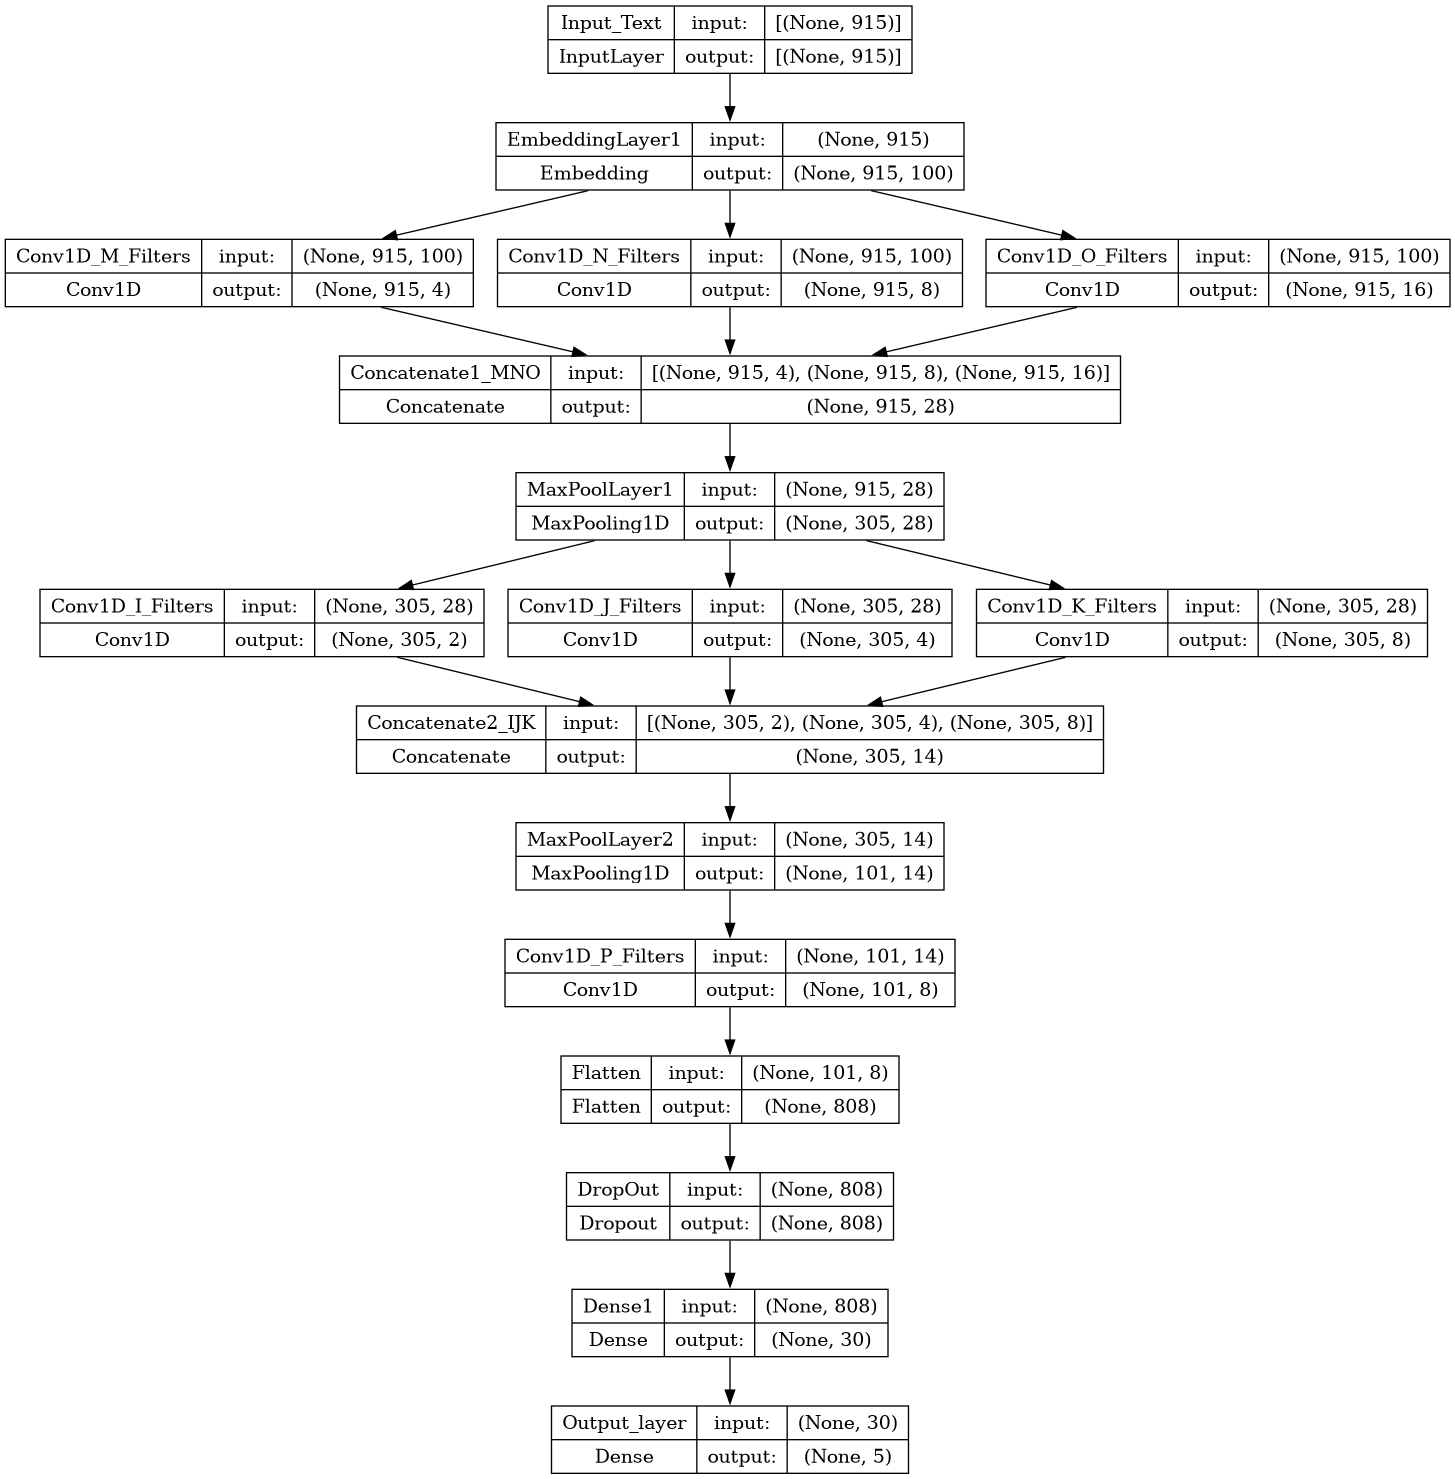

In [350]:
utils.plot_model(model1, "Document_Classification_Model.png", show_shapes=True)

### 6.3 Compile Model

#### Why `sparse_categorical_crossentropy` as loss function?

If targets are one-hot encoded, use `categorical_crossentropy` else if they are list of integers use `sparse_categorical_crossentropy`.

Ref: https://datascience.stackexchange.com/a/55987/103781

In [351]:
model1.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(0.002),
    metrics=["accuracy"],
)

### 6.4 Train Model

#### Handle Imbalanced dataset

In [352]:
cls_weights = {}
for cls, count in y_train.value_counts().sort_index().items():
    cls_weights[cls] = round(1 - (count / len(y_train)), 2)  # Logic 1
    # cls_weights[cls] = (1 / count) * (len(y_train) / 2.0)  # Logic 2

print("Class weights:", cls_weights)


Class weights: {0: 0.81, 1: 0.77, 2: 0.82, 3: 0.83, 4: 0.77}


In [353]:
# cls_weights = {}
# for cls, count in y_train.value_counts().sort_index().items():
#     cls_weights[cls] = (1 / count) * (len(y_train) / 2.0)  # Logic 2

# print("Class weights:", cls_weights)



> **Important Notes:**
> 
> 1. Using `class_weights` may alter the loss range, impacting training stability, particularly with optimizers like `tf.keras.optimizers.SGD()` sensitive to gradient magnitudes.
> 
> 2. Optimizers such as `tf.keras.optimizers.SGD()`, reliant on gradient magnitude, might face challenges when class weights are applied.
> 
> 3. The chosen optimizer, `tf.keras.optimizers.Adam()`, remains unaffected by the scaling change introduced by class weights.
> 
> Reference: [TensorFlow Documentation on Classification with Imbalanced Data](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights)

#### Fit

In [354]:
# import shutil

# # Specify the path to the directory you want to delete
# directory_path = "/kaggle/working/logs"  # Replace with your directory path

# # Check if the directory exists before attempting to delete
# if os.path.exists(directory_path):
#     # Delete the directory and its contents
#     shutil.rmtree(directory_path)
#     print(f"The directory {directory_path} has been deleted.")
# else:
#     print(f"The directory {directory_path} does not exist.")


In [355]:
# FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/models/epoch-{epoch:02d}_accuracy-{val_accuracy:.4f}.keras'

MODELS_DIR = "/kaggle/working/models"

# Check if the directory exists, and create it if not
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)

In [356]:
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

_ = model1.fit(
    x=eX_train,
    y=y_train,
    batch_size=89,
    epochs=15,
    verbose=2,
    callbacks=[
        callbacks.TensorBoard(LOGS_DIR, histogram_freq=1),
        TerminateWhenNaN(),
        PerformanceMetrics(eX_cval, y_cval),
        DecayLearningRate(),
        SaveBetterModel(filepath=MODEL_FILE, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1), #SaveBetterModel(filepath=MODEL_FILE)
        TerminateOnNoChange(epochs=PATIENCE),
    ],
    validation_data=(eX_cval, y_cval),
    # class_weight=cls_weights,
)

Epoch 1/15
16/16 [==============================] - 0s 19ms/step
Epoch 1 - Validation Micro F1 Score: 0.3589

Epoch 1: val_accuracy improved from -inf to 0.3588709533214569, saving model to /kaggle/working/models/epoch-{epoch:02d}_accuracy-{val_accuracy:.4f}.keras
13/13 - 6s - loss: 1.5633 - accuracy: 0.2939 - val_loss: 1.4216 - val_accuracy: 0.3589 - 6s/epoch - 438ms/step
Epoch 2/15
16/16 [==============================] - 0s 19ms/step
Epoch 2 - Validation Micro F1 Score: 0.7177

Epoch 2: val_accuracy improved from -inf to 0.7177419066429138, saving model to /kaggle/working/models/epoch-{epoch:02d}_accuracy-{val_accuracy:.4f}.keras
13/13 - 3s - loss: 1.2014 - accuracy: 0.5376 - val_loss: 0.8160 - val_accuracy: 0.7177 - 3s/epoch - 241ms/step
Epoch 3/15
16/16 [==============================] - 0s 19ms/step
Epoch 3 - Validation Micro F1 Score: 0.8569
Reducing learning rate by 5%. New learning rate: 0.0019

Epoch 3: val_accuracy improved from -inf to 0.8568548560142517, saving model to /k

### 6.5 TensorBoard

Load TensorBoard extension for Jupyter Notebook.

In [357]:
%reload_ext tensorboard

In [358]:
# https://www.kaggle.com/code/aagundez/using-tensorboard-in-kaggle-kernels
# https://www.kaggle.com/code/mukulkirti/6-tensorboard-excercise

%tensorboard --logdir $LOGS_DIR

Reusing TensorBoard on port 6006 (pid 1692), started 0:24:55 ago. (Use '!kill 1692' to kill it.)

Since TensorBoard [has temporarily been disabled][1] in Kaggle kernels. Refer below screenshots for reference.

[1]: https://www.kaggle.com/product-feedback/89671#764494

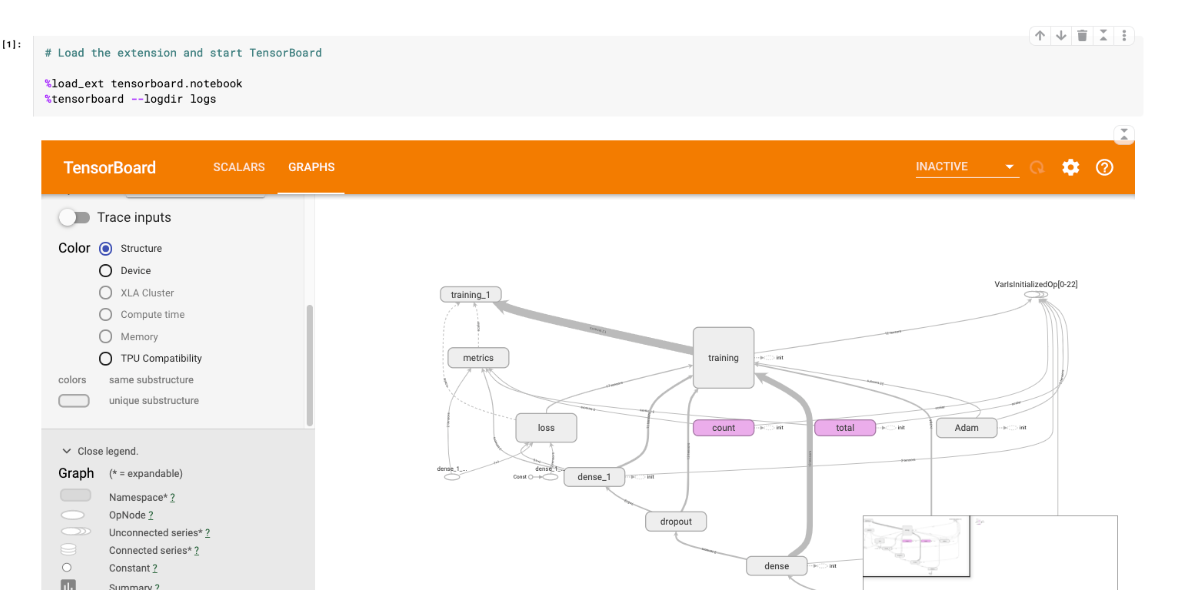

Epoch 1/15
16/16 [==============================] - 0s 24ms/step
Epoch 1 - Validation Micro F1 Score: 0.9597

Epoch 1: val_accuracy improved from -inf to 0.9596773982048035, saving model to /kaggle/working/models/epoch-{epoch:02d}_accuracy-{val_accuracy:.4f}.keras
13/13 - 4s - loss: 0.0446 - accuracy: 0.9853 - val_loss: 0.1348 - val_accuracy: 0.9597 - 4s/epoch - 289ms/step
Epoch 2/15
16/16 [==============================] - 0s 19ms/step
Epoch 2 - Validation Micro F1 Score: 0.9597
13/13 - 3s - loss: 0.0428 - accuracy: 0.9844 - val_loss: 0.1335 - val_accuracy: 0.9597 - 3s/epoch - 252ms/step
Epoch 3/15
16/16 [==============================] - 0s 19ms/step
Epoch 3 - Validation Micro F1 Score: 0.9556
Reducing learning rate by 10%. New learning rate: 0.00125
13/13 - 3s - loss: 0.0371 - accuracy: 0.9905 - val_loss: 0.1483 - val_accuracy: 0.9556 - 3s/epoch - 232ms/step
Epoch 4/15
16/16 [==============================] - 0s 19ms/step
Epoch 4 - Validation Micro F1 Score: 0.9516
Reducing learning

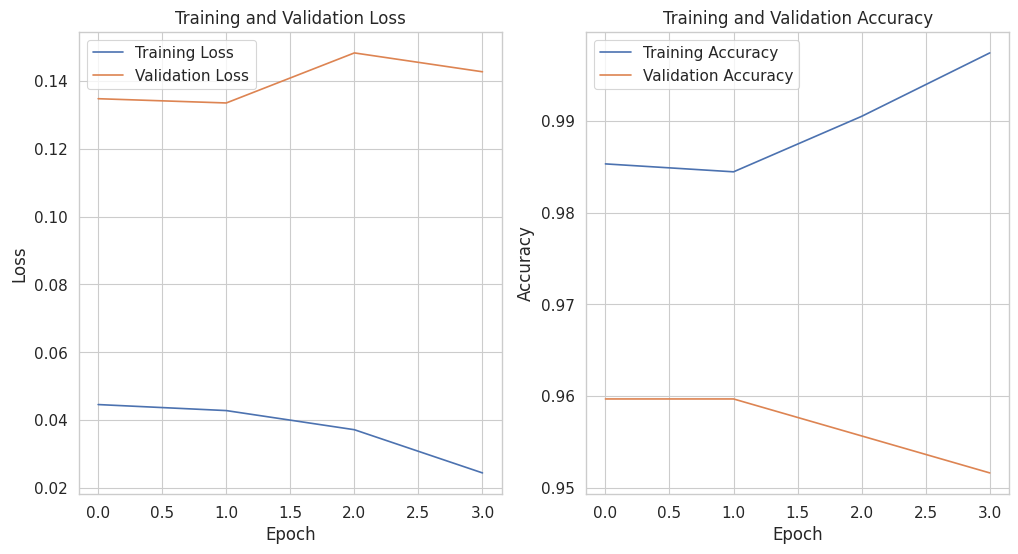

In [359]:
# Set random seeds for reproducibility
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

# Assuming model1.fit is assigned to the variable 'history'
history = model1.fit(
    x=eX_train,
    y=y_train,
    batch_size=89,
    epochs=15,
    verbose=2,
    callbacks=[
        callbacks.TensorBoard(LOGS_DIR, histogram_freq=1),
        TerminateWhenNaN(),
        PerformanceMetrics(eX_cval, y_cval),
        DecayLearningRate(),
        SaveBetterModel(filepath=MODEL_FILE, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1), #SaveBetterModel(filepath=MODEL_FILE)
        TerminateOnNoChange(epochs=PATIENCE),
    ],
    validation_data=(eX_cval, y_cval),
)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Set y-axis ticks for loss
# plt.yticks([i/10 for i in range(11)])  # Sets ticks at 0.0, 0.1, 0.2, ..., 1.0


# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Set y-axis ticks for accuracy
# plt.yticks([i/10 for i in range(11)])  # Sets ticks at 0.0, 0.1, 0.2, ..., 1.0


# Show the plots
plt.show()



1. **Validation Error Reduction and Early Stopping:**
   - A drastic reduction in validation error during the initial epochs is a positive sign. It indicates that the model is learning and improving its ability to generalize to unseen data.
   - The fact that the reduction tapers off suggests that the model may have reached a point where further training does not result in significant improvement on the validation set.
   - Early stopping is a technique that automatically stops training when the model's performance on a validation set stops improving, helping prevent overfitting.

2. **Small Difference Between Train Error and Validation Error:**
   - The small difference between training and validation error suggests that the model is not overfitting.
   - Overfitting occurs when a model learns the training data too well, capturing noise and specifics of the training set that do not generalize to new data.
   - A small gap between train and validation error indicates that the model generalizes well to unseen data.

Overall, these observations suggest that the model is performing reasonably well. May want to consider the trade-off between model complexity and performance, and monitor other metrics (such as accuracy) to get a comprehensive understanding of the model's behavior. If early stopping is triggered, it's often a good idea to save the model at that point, as it likely represents the model's best performance on the validation set.

### 6.6 Validate Model

In [360]:
model1.evaluate(eX_test, y_test, verbose=2)

18/18 - 0s - loss: 0.1458 - accuracy: 0.9583 - 336ms/epoch - 19ms/step


[0.14579738676548004, 0.9583333134651184]

#### Observations

1. Final loss: 0.22
2. Final accuracy: 0.96

> **Note:** [GloVe vectors dataset][1] used in this kernel is are not updated since 6 years. Validation error might reduce if [latest GloVe vectors][2] are used.

[1]: https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation
[2]: https://nlp.stanford.edu/projects/glove/

## 7 Performance Metrics

### 7.1 Confusion Matrix

18/18 [==============================] - 0s 19ms/step


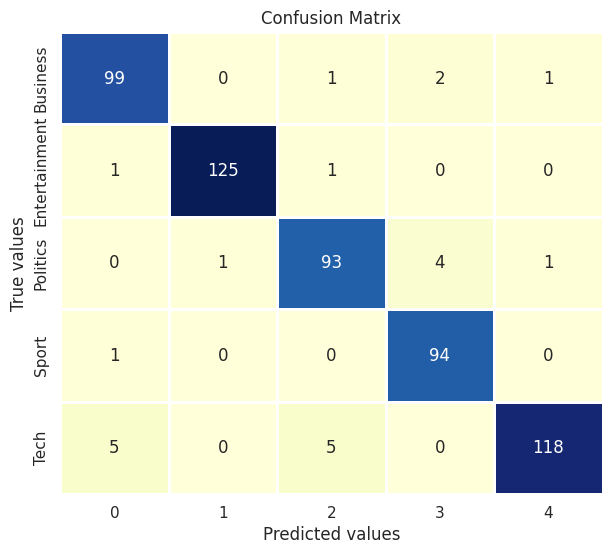

In [361]:
# Predict y_test class-labels
cl_prob = model1.predict(eX_test)
y_pred = np.argmax(cl_prob, axis=1)

# Compute confusion matrix
c_mat = tf.math.confusion_matrix(y_test, y_pred, CLASS_COUNT).numpy()

# Plot confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(
    c_mat,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    cbar=False,
    linecolor="white",
    linewidths=1,
    yticklabels=cls_map.keys(),
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted values")
plt.ylabel("True values")

plt.show()

In [362]:
y_test
# cls_map = {'Business' : 0, 'Entertainment': 1, 'Politics': 2, 'Sport': 3, 'Tech' : 4}

758     1
1911    4
1856    4
1841    4
396     0
       ..
987     2
1705    4
1604    3
138     0
1214    2
Name: DocCat, Length: 552, dtype: int64

In [363]:
import pandas as pd

# Assuming y_test is a pandas Series
y_test_counts = y_test.value_counts()

# Display the counts
print(y_test_counts)


DocCat
4    128
1    127
0    103
2     99
3     95
Name: count, dtype: int64


#### Observations

1. 99 out of 103 (**96%**) documents were correctly predicted as _Business_ class.
2. 125 out of 127 (**98%**) documents were correctly predicted as _Entertainment_ class.
3. 93 out of 99 (**94%**) documents were correctly predicted as _Politics_ class.
4. 94 out of 95 (**99%**) documents were correctly predicted as _Sport_ class.
5. 118 out of 128 (**92%**) documents were correctly predicted as _Tech_ class.
6. Documents of class _Tech_ has **most number of wrong predictions**. 
7. Six documents related to politics are wrongly predicted as classes _Entertainment_, _Sport_, _Tech_ . 
8. Ten documents related to technology are wrongly predicted as class _Business_, _Politics_ .

Guidance from:

https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation

https://www.kaggle.com/code/dheemanthbhat/bbc-text-classification-part-2-modeling

https://nlp.stanford.edu/projects/glove/

https://docs.scipy.org/doc/scipy/reference/spatial.distance.html

https://www.tensorflow.org/guide/keras/writing_your_own_callbacks

https://keras.io/api/callbacks/early_stopping/

https://stackoverflow.com/questions/43151775/how-to-have-parallel-convolutional-layers-in-keras/45304179#45304179

https://datascience.stackexchange.com/questions/41921/sparse-categorical-crossentropy-vs-categorical-crossentropy-keras-accuracy/55987#55987

https://www.kaggle.com/code/dheemanthbhat/bbc-text-classification-part-2-modeling/notebook

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights

https://www.kaggle.com/code/aagundez/using-tensorboard-in-kaggle-kernels

https://www.kaggle.com/code/mukulkirti/6-tensorboard-excercise